# Halpha Emitters S-PLUS

In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from itertools import combinations
import umap
import warnings
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

2025-01-20 01:25:30.853132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 01:25:30.932965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 01:25:30.955942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 01:25:31.092959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 01:25:32.475740: W tensorflow/compiler/tf2

In [2]:
warnings.filterwarnings("ignore", message="n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.")

In [3]:
combined_df = pd.read_csv("../Ha-emitters/Halpha_Mine_PerField_total-unique.csv")    

In [4]:

combined_df

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,J0410_psf,e_J0410_psf,J0430_psf,e_J0430_psf,J0515_psf,e_J0515_psf,J0660_psf,e_J0660_psf,J0861_psf,e_J0861_psf
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,16.869030,0.045,16.612030,0.040,15.790031,0.034,14.886657,0.028,14.564144,0.031
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,13.345949,0.016,13.265827,0.014,13.113828,0.012,13.033432,0.020,13.019970,0.019
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,15.504150,0.011,15.336150,0.009,14.717150,0.007,14.074205,0.016,NaN,NaN
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,NaN,NaN,NaN,NaN,15.129318,0.027,NaN,NaN,NaN,NaN
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,15.852819,0.022,15.775820,0.015,15.204820,0.023,15.071949,0.020,15.141534,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3632,b'STRIPE82-0157',b'iDR4_3_STRIPE82-0157_0016873',349.808612,-0.962720,7268.3916,3780.7950,0.000391,1.049551,8.169368e-07,3.894912,...,NaN,NaN,NaN,NaN,20.401480,0.137,18.918780,0.100,18.550900,0.059
3633,b'STRIPE82-0158',b'iDR4_3_STRIPE82-0158_0009177',350.254869,0.323001,4347.6445,3032.8470,0.000335,0.986151,6.768905e-07,4.712428,...,19.580069,0.111,19.594069,0.104,19.548069,0.088,18.961864,0.039,19.223470,0.122
3634,b'STRIPE82-0162',b'iDR4_3_STRIPE82-0162_0018498',352.418578,0.670626,8739.1020,5308.4004,0.000349,1.035019,6.068673e-07,3.826304,...,NaN,NaN,NaN,NaN,20.593569,0.147,17.811909,0.155,18.467216,0.062
3635,b'STRIPE82-0163',b'iDR4_3_STRIPE82-0163_0014886',354.578466,-0.927664,3879.0051,4010.2715,0.000404,1.171372,4.901620e-07,4.799046,...,NaN,NaN,NaN,NaN,20.541643,0.192,19.062990,0.052,18.447079,0.067


In [5]:
for columns in combined_df.columns:
    print(columns)

Field
ID
RA
DEC
X
Y
FWHM
FWHM_n
ISOarea
KRON_RADIUS
MU_MAX_INST
PETRO_RADIUS
SEX_FLAGS_DET
SEX_NUMBER_DET
CLASS_STAR
s2n_DET_PStotal
THETA
ELLIPTICITY
ELONGATION
FLUX_RADIUS_20
FLUX_RADIUS_50
FLUX_RADIUS_70
FLUX_RADIUS_90
s2n_r_PStotal
s2n_J0660_PStotal
s2n_i_PStotal
FWHM_r
FWHM_n_r
FWHM_J0660
FWHM_n_J0660
FWHM_i
FWHM_n_i
SEX_FLAGS_r
SEX_FLAGS_J0660
SEX_FLAGS_i
CLASS_STAR_r
CLASS_STAR_J0660
CLASS_STAR_i
r_PStotal
e_r_PStotal
g_PStotal
e_g_PStotal
i_PStotal
e_i_PStotal
u_PStotal
e_u_PStotal
z_PStotal
e_z_PStotal
J0378_PStotal
e_J0378_PStotal
J0395_PStotal
e_J0395_PStotal
J0410_PStotal
e_J0410_PStotal
J0430_PStotal
e_J0430_PStotal
J0515_PStotal
e_J0515_PStotal
J0660_PStotal
e_J0660_PStotal
J0861_PStotal
e_J0861_PStotal
r_psf
e_r_psf
g_psf
e_g_psf
i_psf
e_i_psf
u_psf
e_u_psf
z_psf
e_z_psf
J0378_psf
e_J0378_psf
J0395_psf
e_J0395_psf
J0410_psf
e_J0410_psf
J0430_psf
e_J0430_psf
J0515_psf
e_J0515_psf
J0660_psf
e_J0660_psf
J0861_psf
e_J0861_psf


In [6]:
# Cleaned error
m_err = (combined_df["e_r_PStotal"] <= 0.2) & (combined_df["e_g_PStotal"] <= 0.2) & \
        (combined_df["e_i_PStotal"] <= 0.2) & (combined_df["e_u_PStotal"] <= 0.2) & \
        (combined_df["e_J0378_PStotal"] <= 0.2) & (combined_df["e_J0395_PStotal"] <= 0.2) & \
        (combined_df["e_J0410_PStotal"] <= 0.2) & (combined_df["e_J0430_PStotal"] <= 0.2) & \
        (combined_df["e_J0515_PStotal"] <= 0.2) & (combined_df["e_J0660_PStotal"] <= 0.2) & \
        (combined_df["e_J0861_PStotal"] <= 0.2) & (combined_df["e_z_PStotal"] <= 0.2)


In [7]:
df_cleanErr = combined_df[m_err]
len(df_cleanErr)

2181

In [8]:
#Selecting columns
columns = ["r_PStotal",
"g_PStotal",
"i_PStotal",
"u_PStotal",
"z_PStotal",
"J0378_PStotal",
"J0395_PStotal",
"J0410_PStotal",
"J0430_PStotal",
"J0515_PStotal",
"J0660_PStotal",
"J0861_PStotal"]

In [9]:
df_mag = df_cleanErr[columns]
df_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,14.816056,14.486720
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,12.990587,12.979302
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,14.003431,13.810323
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,14.518179,14.313604
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,15.035774,15.058778
...,...,...,...,...,...,...,...,...,...,...,...,...
3619,18.613853,18.923706,18.582360,19.189054,18.201460,18.717813,19.045317,18.990812,18.943542,18.894592,18.374134,18.431206
3623,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,18.828121,19.304344
3627,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,18.536316,18.690256
3629,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,18.574770,18.961899


### Creating the colors 

In [10]:
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

66

In [11]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [12]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/tmp/ipykernel_44353/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_44353/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_44353/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [13]:
df_colors_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,18.613853,18.923706,18.582360,19.189054,18.201460,18.717813,19.045317,18.990812,18.943542,18.894592,...,0.047270,0.096220,0.616678,0.559606,0.048950,0.569408,0.512336,0.520458,0.463386,-0.057072
3623,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
3627,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
3629,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129


In [14]:
# Drop magniytudes
df_colors = df_colors_mag.drop(columns=columns)

In [15]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,-0.309853,0.031493,-0.575201,0.412393,-0.103960,-0.431464,-0.376959,-0.329689,-0.280739,0.239719,...,0.047270,0.096220,0.616678,0.559606,0.048950,0.569408,0.512336,0.520458,0.463386,-0.057072
3623,-0.385913,0.021193,-0.400243,-0.121358,-0.244292,-0.337652,-0.389431,-0.369268,-0.392612,0.355147,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
3627,-0.450952,0.119095,-0.429224,0.151297,-0.388830,-0.413261,-0.618225,-0.593130,-0.363956,0.350918,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
3629,-0.534901,-0.015257,-1.513470,-0.119953,-1.412008,-0.814728,-0.914442,-1.044880,-0.356613,0.268484,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129


# Reduction dimensionality

## UMAP 

Given that there are 66 variables, we use UMAP. I think UMAP is the best option because these variables are probably not linearly correlated. [UMAP](https://umap-learn.readthedocs.io/en/latest/) (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces. If you have 66 variables and suspect they are not linearly correlated, UMAP could be a suitable method for exploring the structure of your data in a lower-dimensional space while preserving non-linear relationships. However, the effectiveness of UMAP depends on various factors, including the nature of your data and the specific goals of your analysis. It's always a good idea to experiment with different techniques and evaluate their performance based on your data and objectives.

In [16]:
# Standarized the data
X_stand = StandardScaler().fit_transform(df_colors)

#### Try cross-validation 

To perform cross-validation for choosing the optimal number of components in UMAP.

In [17]:
# Split data into training and validation sets
X_train, X_val = train_test_split(X_stand, test_size=0.2, random_state=42)

In [18]:
# Define a range of number of components to try
n_components_range = [2, 3, 4, 5, 10, 20, 50]
n_neighbors_range = [5, 10, 15, 20, 30, 50, 70, 100]

# Initialize best scores and parameters
best_silhouette_score = -1
best_davies_bouldin_score = float('inf')
best_num_components = None
best_n_neighbors = None
best_labels = None

In [19]:
# Set a fixed random state for KMeans reproducibility
random_state = 42

# Loop over different numbers of components and neighbors
for num_components in n_components_range:
    for n_neighbors in n_neighbors_range:
        # Fit UMAP model without random_state for parallelism
        reducer_ = umap.UMAP(n_neighbors=n_neighbors, n_components=num_components)
        X_train_trans = reducer_.fit_transform(X_train)

        # Cluster the transformed data using KMeans
        kmeans = KMeans(n_clusters=num_components, random_state=random_state)
        labels = kmeans.fit_predict(X_train_trans)

        # Evaluate performance using Silhouette Score and Davies-Bouldin Index
        silhouette = silhouette_score(X_train_trans, labels)
        davies_bouldin = davies_bouldin_score(X_train_trans, labels)
        print(f"Components: {num_components}, Neighbors: {n_neighbors}, Silhouette Score: {silhouette}, DB Index: {davies_bouldin}")

        # Update best parameters based on combined metrics
        if silhouette > best_silhouette_score and davies_bouldin < best_davies_bouldin_score:
            best_silhouette_score = silhouette
            best_davies_bouldin_score = davies_bouldin
            best_num_components = num_components
            best_n_neighbors = n_neighbors
            best_labels = labels

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin_score}")
print(f"Best Number of Components: {best_num_components}")
print(f"Best Number of Neighbors: {best_n_neighbors}")

Components: 2, Neighbors: 5, Silhouette Score: 0.479765385389328, DB Index: 0.8077311945496601
Components: 2, Neighbors: 10, Silhouette Score: 0.7037637233734131, DB Index: 0.3823010732493362
Components: 2, Neighbors: 15, Silhouette Score: 0.7082505822181702, DB Index: 0.39493824781180126
Components: 2, Neighbors: 20, Silhouette Score: 0.7479546070098877, DB Index: 0.3282984081741175
Components: 2, Neighbors: 30, Silhouette Score: 0.7906148433685303, DB Index: 0.26367269180390324
Components: 2, Neighbors: 50, Silhouette Score: 0.7194269895553589, DB Index: 0.34311671051432113
Components: 2, Neighbors: 70, Silhouette Score: 0.7455934286117554, DB Index: 0.3210948945369401
Components: 2, Neighbors: 100, Silhouette Score: 0.664275586605072, DB Index: 0.3916144095388712
Components: 3, Neighbors: 5, Silhouette Score: 0.5473598837852478, DB Index: 0.6313816330749425
Components: 3, Neighbors: 10, Silhouette Score: 0.584869921207428, DB Index: 0.5608407460831814
Components: 3, Neighbors: 15, S

In [21]:
# Output best parameters and corresponding silhouette score
print(f"Best number of components: {best_num_components}, Best number of neighbors: {best_n_neighbors}, Best Silhouette Score: {best_silhouette_score}")


Best number of components: 2, Best number of neighbors: 30, Best Silhouette Score: 0.7906148433685303


#### Try UMAP

In [42]:
num_components = 2
reducer = umap.UMAP(n_neighbors=30, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                    n_components=num_components,  # min_samples=15, min_cluster_size=60
                    random_state=42)
X_trans = reducer.fit_transform(X_stand)

Visualize the cumulative explained variance ratio:

In [43]:
# Calculate the variance of the original data points in the reduced space
original_variance = np.var(X_trans, axis=0)

# Calculate the explained variance ratio
explained_variance_ratio = original_variance / np.sum(original_variance)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

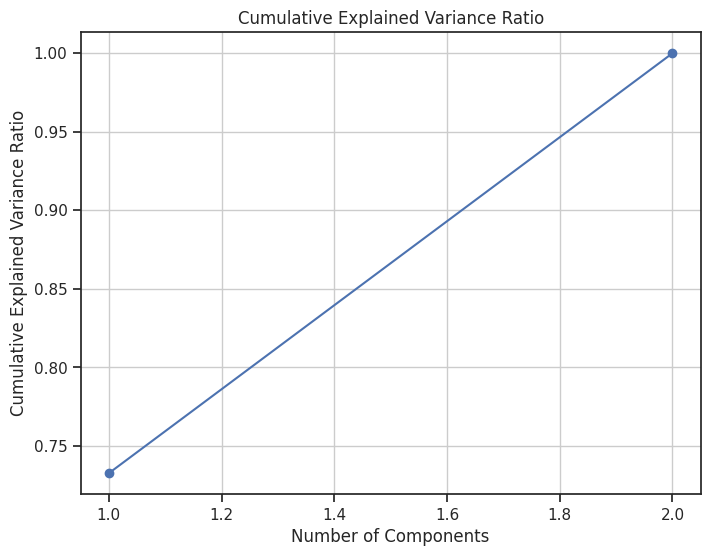

In [44]:
# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [45]:
#umap_df = pd.DataFrame(X_trans, columns = ["PC1", "PC2", "PC3"])
# Create a DataFrame for PCA results
umap_columns = [f'PC{i}' for i in range(1, num_components + 1)]
umap_df = pd.DataFrame(data=X_trans, columns=umap_columns)
umap_df

,PC1,PC2
0,-5.442610,7.757478
1,-2.864902,15.890388
2,-6.490024,10.687394
3,-6.868538,9.669092
4,-4.440413,15.294579
...,...,...
2176,9.469851,3.271471
2177,13.036900,3.766674
2178,11.649218,4.006531
2179,-5.515374,15.548613


/tmp/ipykernel_44353/1329027073.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', 10))


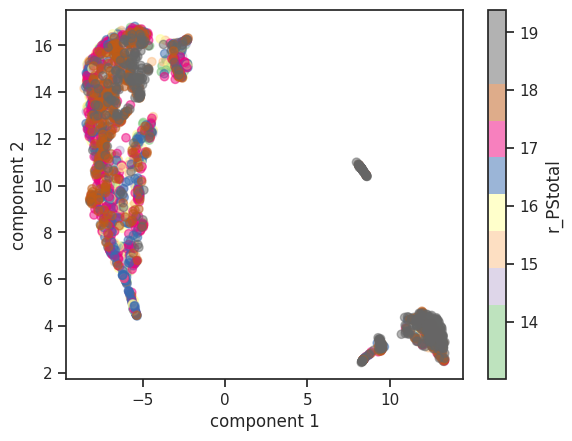

In [47]:
# Assuming umap_df is your DataFrame containing UMAP components and g_PStotal column
plt.scatter(umap_df["PC1"], umap_df["PC2"],
            c=df_cleanErr["r_PStotal"],  # Set color based on the values of "g_PStotal"
            alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='r_PStotal')  # Set the label of the color bar to 'g_PStotal'
plt.show()

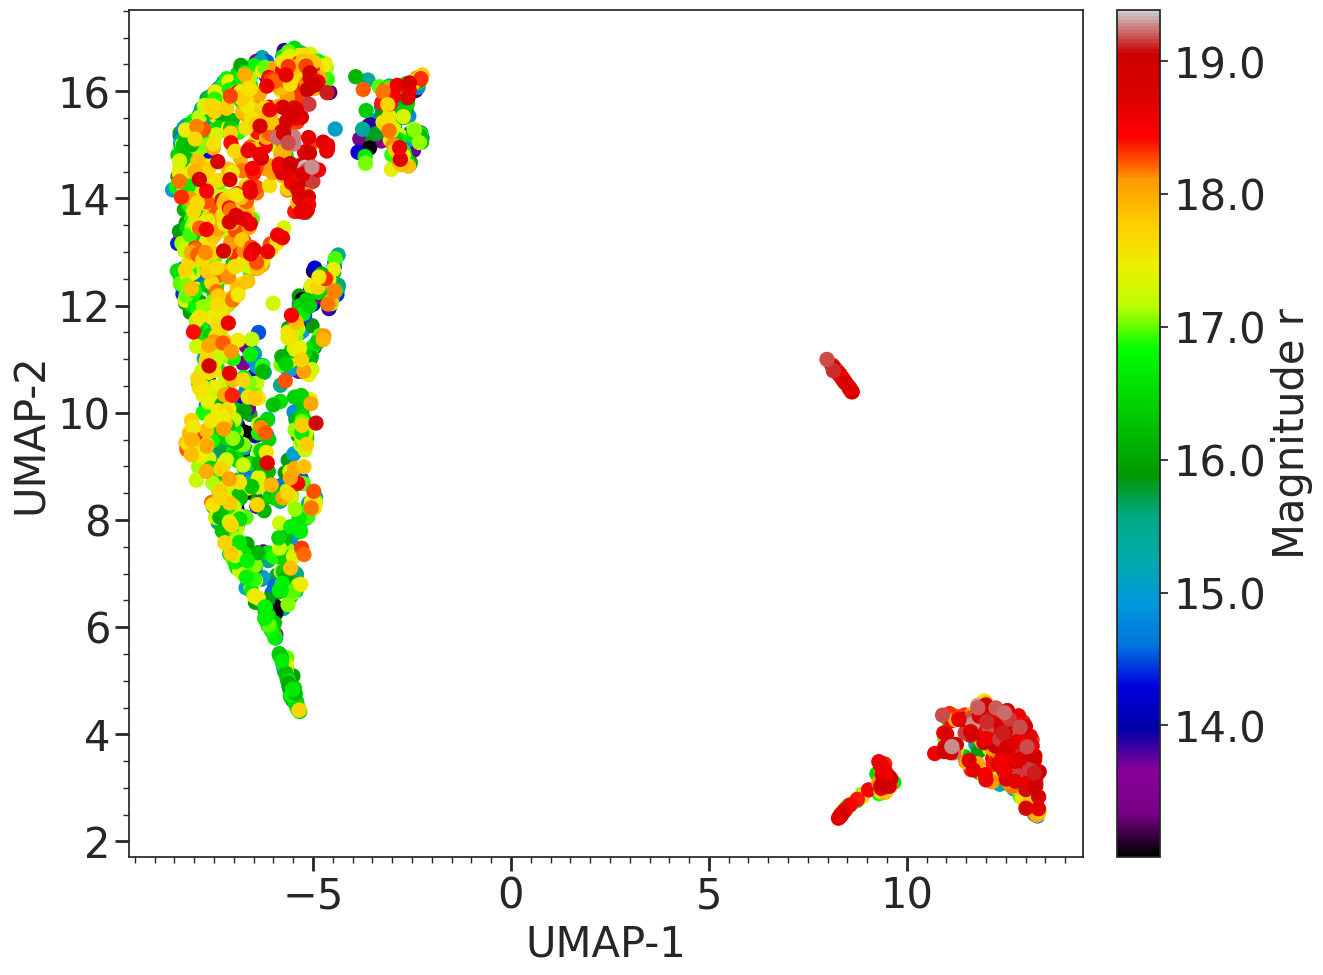

In [48]:
from matplotlib.ticker import MultipleLocator, NullFormatter

# Plotting
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(15, 11))
    plt.xlabel("UMAP-1", fontsize=30)
    plt.ylabel("UMAP-2", fontsize=30)
    plt.tick_params(axis='x', labelsize=30, width=2, length=10)  # Adjusting width of tick marks
    plt.tick_params(axis='y', labelsize=30, width=2, length=10)  # Adjusting width of tick marks

    # Create a scatter plot
    sc = ax.scatter(umap_df["PC1"], umap_df["PC2"], c=df_cleanErr["r_PStotal"], cmap="nipy_spectral", s=100)
    
    # Add minor tick locators without showing the minor ticks
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # Add a colorbar with improved visibility
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, format='%.1f')
    cbar.set_label("Magnitude r", fontsize=30)  # Provide a label for the colorbar
    cbar.ax.tick_params(labelsize=30)  # Adjust the size of the tick labels

plt.savefig("../Figs/umap_splus.pdf")

## HDBSCAN 

#### Find the best parameters 

To find the best min_samples and min_cluster_size parameters for HDBSCAN, you typically perform a grid search over a range of values and evaluate the clustering performance using a metric such as silhouette score or another relevant metric.

Here's a general approach you can follow:

    Define a grid of parameters to search over for min_samples and min_cluster_size.
    For each combination of parameters:
        Fit HDBSCAN to your data.
        Evaluate the clustering performance using a metric such as silhouette score.
    Select the parameters that result in the highest clustering performance according to your chosen metric.

Here's how you can perform this grid search:

In [27]:

# Define the range of values for min_samples and min_cluster_size
min_samples_range = [5, 10, 15, 20, 25, 30, 35]  # Adjust as needed
min_cluster_size_range = [40, 50, 60, 80, 100, 120, 150]  # Adjust as needed

In [28]:
best_score = -1
best_params = {}


In [29]:
for min_samples in min_samples_range:
    for min_cluster_size in min_cluster_size_range:
        # Fit HDBSCAN with the current parameters
        clusterer_ = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
        labels = clusterer_.fit_predict(X_trans)  # X is your data
        
        # Evaluate clustering performance using silhouette score
        silhouette_ = silhouette_score(X_trans, labels)
        
        # Check if current parameters result in a better silhouette score
        if silhouette_ > best_score:
            best_score = silhouette_
            best_params['min_samples'] = min_samples
            best_params['min_cluster_size'] = min_cluster_size

# print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

### Applying HDBSCAN 

I foun that the best configurations of parameteres are 'min_samples': 5 and 'min_cluster_size': 100. We try then: 
But first try this min_samples=15, min_cluster_size=60

In [45]:
clusterer = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=50, 
                             prediction_data=True, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=1, gen_min_span_tree=True)


In [46]:

clusterer.fit(X_trans)
labels = clusterer.labels_
len(labels)

2181

In [47]:
clusterer.metric

'euclidean'

In [48]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_noise_ = list(labels).count(-1)


In [49]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of cluster points 0: 58
Estimated number of cluster points 1: 166
Estimated number of cluster points 2: 1539
Estimated number of cluster points 3: 93
Estimated number of noise points: 0


<Axes: >

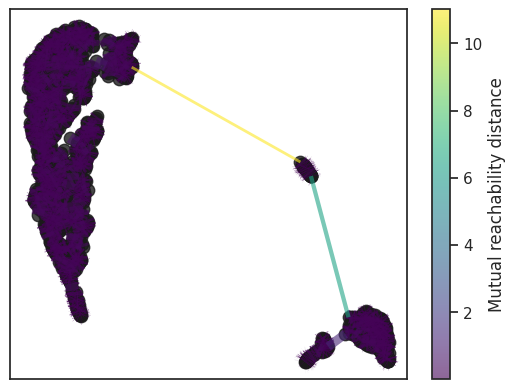

In [50]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)


### Build the cluster hierarchy 

<Axes: ylabel='distance'>

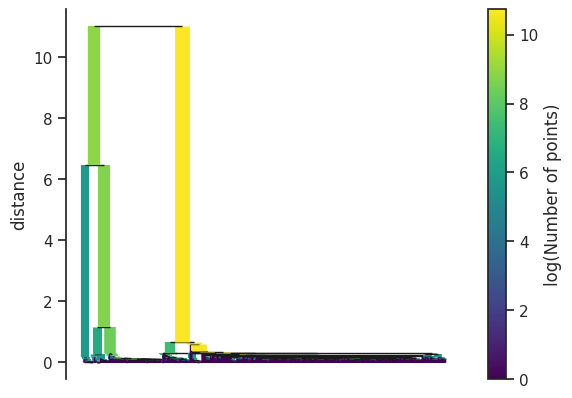

In [51]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Extract the clusters

<Axes: ylabel='$\\lambda$ value'>

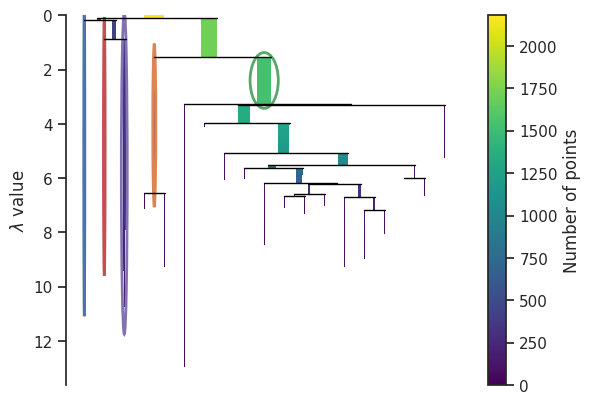

In [52]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Plting the components

<Axes: xlabel='PC1', ylabel='PC2'>

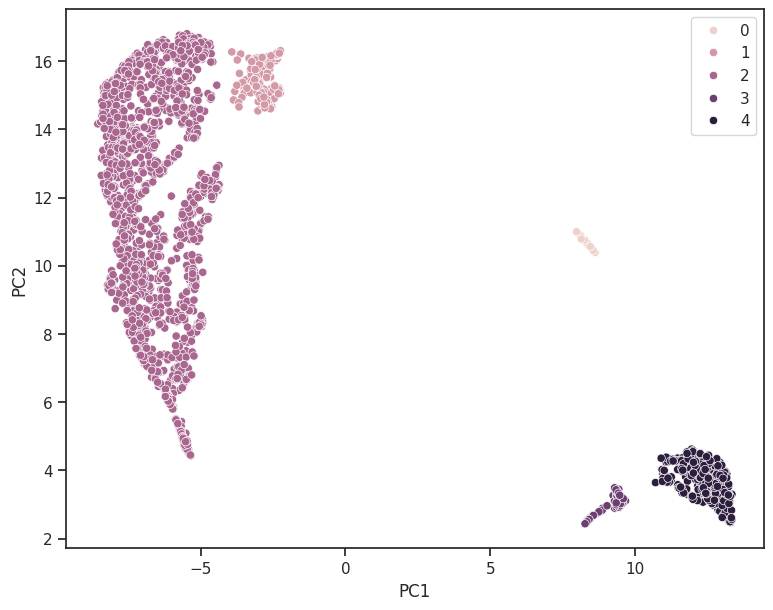

In [53]:

plt.figure(figsize=(9,7))
sns.scatterplot(x=umap_df["PC1"], y=umap_df["PC2"], 
                hue=labels,
                )

In [54]:
# Concatenat the original claen table with the umap results
df_cleanErr.reset_index(drop=True, inplace=True)
umap_df.reset_index(drop=True, inplace=True)
df_cleanErr_umap = pd.concat([df_cleanErr, umap_df], axis=1)
df_cleanErr_umap

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,J0430_psf,e_J0430_psf,J0515_psf,e_J0515_psf,J0660_psf,e_J0660_psf,J0861_psf,e_J0861_psf,PC1,PC2
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,16.612030,0.040,15.790031,0.034,14.886657,0.028,14.564144,0.031,-5.442610,7.757478
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,13.265827,0.014,13.113828,0.012,13.033432,0.020,13.019970,0.019,-2.864902,15.890388
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,15.336150,0.009,14.717150,0.007,14.074205,0.016,NaN,NaN,-6.490024,10.687394
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,NaN,NaN,15.129318,0.027,NaN,NaN,NaN,NaN,-6.868538,9.669092
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,15.775820,0.015,15.204820,0.023,15.071949,0.020,15.141534,0.030,-4.440413,15.294579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,b'STRIPE82-0132',b'iDR4_3_STRIPE82-0132_0011586',331.997487,0.289613,3249.1740,2814.3223,0.000363,1.000263,1.213735e-06,4.081015,...,18.992230,0.054,19.004229,0.046,18.468687,0.028,18.563194,0.056,9.469851,3.271471
2177,b'STRIPE82-0142',b'iDR4_3_STRIPE82-0142_0014029',339.139727,0.448016,2885.1482,3851.2144,0.000379,1.013615,6.535494e-07,4.638296,...,19.544977,0.113,19.558977,0.101,18.884567,0.041,19.348486,0.141,13.036900,3.766674
2178,b'STRIPE82-0147',b'iDR4_3_STRIPE82-0147_0003349',343.495206,-1.289140,2208.1868,1643.8495,0.000305,0.945969,7.469136e-07,3.516137,...,19.491743,0.080,19.246742,0.066,18.590178,0.029,18.753134,0.091,11.649218,4.006531
2179,b'STRIPE82-0151',b'iDR4_3_STRIPE82-0151_0033785',346.434130,-0.425545,1524.9784,7296.7880,0.000348,0.984726,6.535494e-07,3.597043,...,19.924389,0.120,19.170390,0.065,18.583260,0.032,18.903078,0.097,-5.515374,15.548613


Create the tables for each clase

In [55]:
df_cleanErr_umap["Label"] = labels

In [56]:
df_cleanErr_umap

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,e_J0430_psf,J0515_psf,e_J0515_psf,J0660_psf,e_J0660_psf,J0861_psf,e_J0861_psf,PC1,PC2,Label
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,0.040,15.790031,0.034,14.886657,0.028,14.564144,0.031,-5.442610,7.757478,2
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,0.014,13.113828,0.012,13.033432,0.020,13.019970,0.019,-2.864902,15.890388,1
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,0.009,14.717150,0.007,14.074205,0.016,NaN,NaN,-6.490024,10.687394,2
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,NaN,15.129318,0.027,NaN,NaN,NaN,NaN,-6.868538,9.669092,2
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,0.015,15.204820,0.023,15.071949,0.020,15.141534,0.030,-4.440413,15.294579,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,b'STRIPE82-0132',b'iDR4_3_STRIPE82-0132_0011586',331.997487,0.289613,3249.1740,2814.3223,0.000363,1.000263,1.213735e-06,4.081015,...,0.054,19.004229,0.046,18.468687,0.028,18.563194,0.056,9.469851,3.271471,3
2177,b'STRIPE82-0142',b'iDR4_3_STRIPE82-0142_0014029',339.139727,0.448016,2885.1482,3851.2144,0.000379,1.013615,6.535494e-07,4.638296,...,0.113,19.558977,0.101,18.884567,0.041,19.348486,0.141,13.036900,3.766674,4
2178,b'STRIPE82-0147',b'iDR4_3_STRIPE82-0147_0003349',343.495206,-1.289140,2208.1868,1643.8495,0.000305,0.945969,7.469136e-07,3.516137,...,0.080,19.246742,0.066,18.590178,0.029,18.753134,0.091,11.649218,4.006531,4
2179,b'STRIPE82-0151',b'iDR4_3_STRIPE82-0151_0033785',346.434130,-0.425545,1524.9784,7296.7880,0.000348,0.984726,6.535494e-07,3.597043,...,0.120,19.170390,0.065,18.583260,0.032,18.903078,0.097,-5.515374,15.548613,2


**Preliminary conlusions**
Wiht the parameters recomended by the Silhouette HDBSCAM fin two group...

In [57]:
# Group the data based on the "Label" column
grouped_data = df_cleanErr_umap.groupby("Label")

In [58]:
# Define the directory where you want to save the CSV files
directory = '../Class_main_unique/'

In [59]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_noise.csv'
    else:
        filename = f'Halpha_emitter_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)